# Creation of cell data for segmentation benchmarking

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tifffile as tiff
import skimage as sk
from copy import copy
import imageio, elasticdeform
from scipy.ndimage import gaussian_filter, zoom, rotate, minimum_filter
import cv2

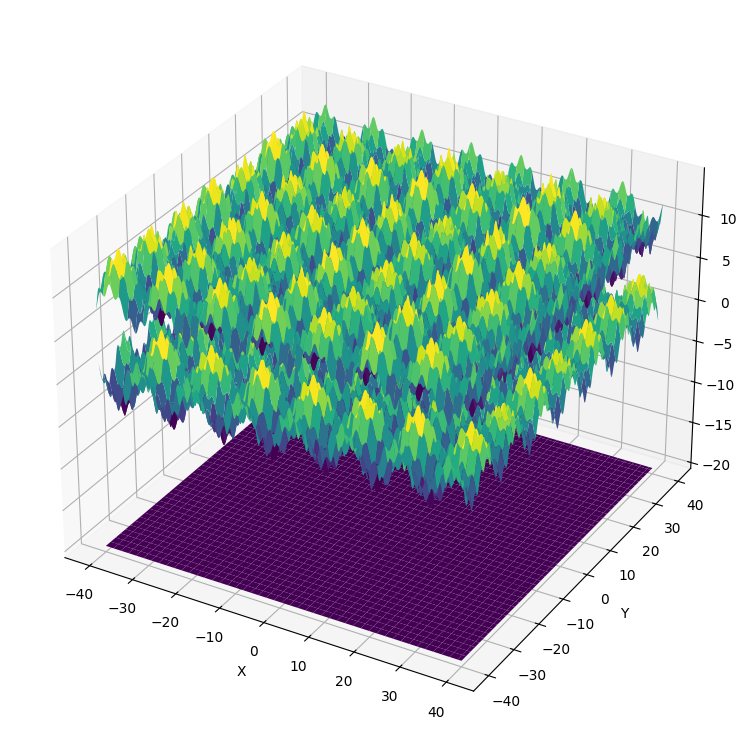

In [22]:
tp = str(0)

# Create a grid of x and y values
resolution = 500
size = 40
x = np.linspace(-size,  size,  resolution+1)
y = np.linspace(-size,  size,  resolution+1)
x, y = np.meshgrid(x, y)

if tp == '0':
    augment = 1.8 # How big sinus is
    displacement = 0 # Difference between the top and the bottom
    mult = 5 # How much wrinkled is the cell
    div = 3 # How smooth the wrinkles are
    displacement_up = 10 # Move the top layer up
    # z1 = augment*np.sin(x/augment+displacement)+augment*np.sin(mult*x/augment)/div+augment*np.sin(y/augment+displacement)+augment*np.sin(mult*y/augment)/div
    z2 = -augment*np.sin(x/augment)-augment*np.sin(mult*x/augment)/div-augment*np.sin(y/augment)-augment*np.sin(mult*y/augment)/div+displacement_up # apical
    z1 = augment*np.sin(x/augment)+augment*np.sin(mult*x/augment)/div+augment*np.sin(y/augment)+augment*np.sin(mult*y/augment)/div # basal






z3 = 0*x+0*y-20

# Create a list of z arrays
z_arrays = [z1, z2, z3]  # Add more z arrays to the list as needed


# Create a figure with subplots
fig = plt.figure(figsize=(15,  15))

# Create a  3D subplot for each z array
ax = fig.add_subplot(2,  2, 1, projection='3d')

for i, z in enumerate(z_arrays):
    ax.plot_surface(x, y, z, cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


plt.tight_layout()
plt.show()

(500, 500, 500)


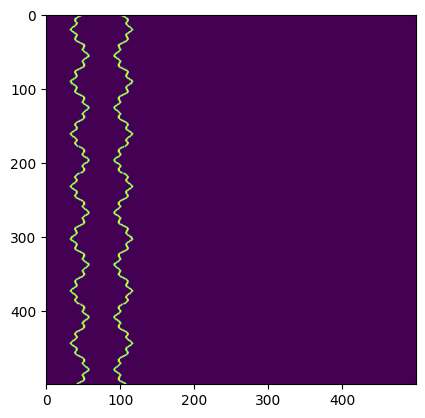

In [21]:
d3_array = np.zeros(shape=(resolution, resolution, resolution))

def update_d3_array(z, d3_array):
    for i in range(z.shape[0]-1):
        for j in range(z.shape[1]-1):
            if not np.isnan(z[i][j]):
                if tp == '0':
                    d3_array[i][j][int(z[i][j]*5+50)] =  1
                
                
# Update d3_array with each z array
update_d3_array(z1, d3_array)
update_d3_array(z2, d3_array)



def normalize_image(im, mult_factor = 1):
    '''
    Normalize image 0-1 and multiply by any factor
    '''
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im



cell_write = './../ppujol/benchmarking/dome1.tif'
# d3_array = sk.morphology.binary_dilation(d3_array, footprint=sk.morphology.ball(2))
d3_array=d3_array.astype(np.uint8)

# Calculate the sum along axis  2
column_sums = np.sum(d3_array, axis=2)
d3_array_2 = np.transpose(d3_array, axes=(2, 1, 0))
# Find the indices of the columns that sum to zero
zero_sum_indices = np.where(column_sums[:,0] ==  0)

d3_array_2 = np.delete(d3_array, zero_sum_indices, axis=1)

zero_sum_indices = np.where(column_sums[0,:] ==  0)

d3_array_2 = np.delete(d3_array_2, zero_sum_indices, axis=0)


d3_array_2 = sk.morphology.binary_dilation(d3_array_2, footprint=sk.morphology.ball(1))
d3_array_2=d3_array_2.astype(np.uint8)

print(d3_array_2.shape)

plt.imshow(d3_array_2[100])

In [210]:
d3_array_2 = np.transpose(d3_array_2, axes=(2, 1, 0))
d3_array_2 = d3_array_2[::-1, :, :]
d3_array_2 = d3_array_2[:, 8:-7, 8:-7]
d3_array_2.shape

(500, 485, 485)

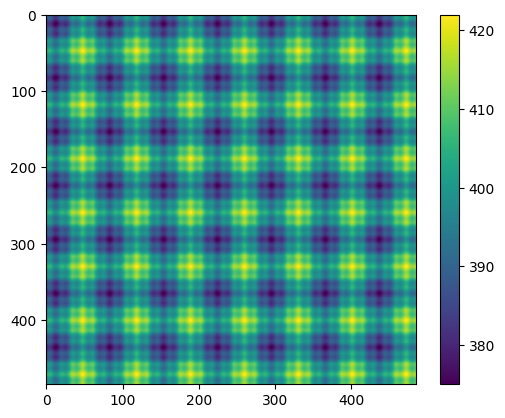

In [211]:
plt.imshow(np.argmax(d3_array_2 != 0, axis=0))
plt.colorbar()

In [212]:
# tiff.imwrite('./../ppujol/mypose_benchmark/wrinkled_cells_tp'+tp+'.tif', d3_array_2.astype(np.uint16), imagej=True)

(500, 485, 485)


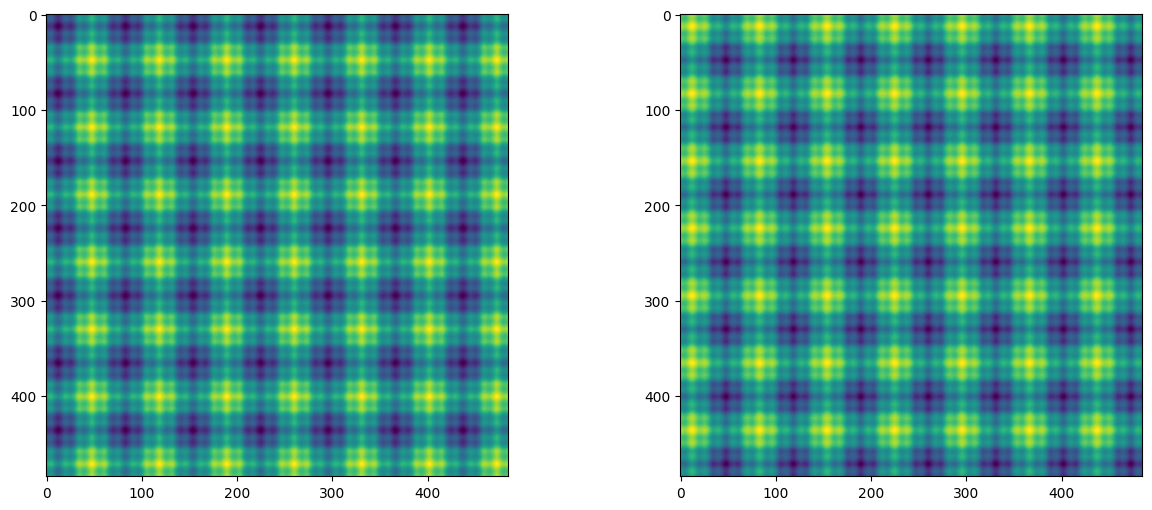

In [213]:
first_nonzero_indices = np.argmax(d3_array_2 != 0, axis=0) ##### THis is the solution where the heightmap should go!!!!
d3_array_3 = np.zeros_like(d3_array_2)
print(d3_array_3.shape)
d3_array_3[first_nonzero_indices[None, :, :], np.arange(d3_array_2.shape[1])[None, :, None], np.arange(d3_array_2.shape[2])] = 1

last_nonzero_indices = np.argmax(d3_array_2[::-1] != 0, axis=0)
last_nonzero_indices = d3_array_2.shape[0]-last_nonzero_indices
d3_array_4 = np.zeros_like(d3_array_2)
d3_array_4[last_nonzero_indices[None, :, :], np.arange(d3_array_2.shape[1])[None, :, None], np.arange(d3_array_2.shape[2])] = 1

plt.figure(figsize=(15,6))
plt.subplot(121)
plt.imshow(first_nonzero_indices)
plt.subplot(122)
plt.imshow(last_nonzero_indices)

In [214]:
def get_r(image):
    image_r = np.transpose(image, axes=(1,0,2))
    return image_r

def get_top(image_r):
    image = np.transpose(image_r, axes=(1, 2, 0))
    image = np.rot90(image, axes=(1,2))
    return image

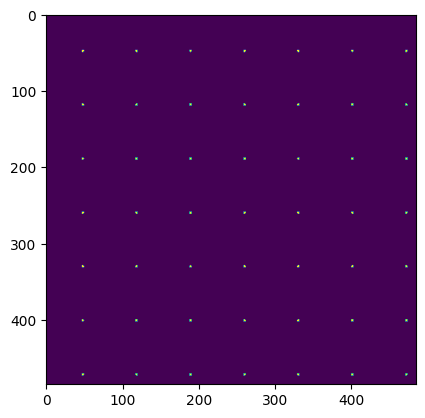

In [215]:
# Define the size of the neighborhood for finding local minima
neighborhood_size = 100
if tp == '2' or tp == '4':
    neighborhood_size = 30

# Apply a minimum filter over the array to find local minima
local_minima = minimum_filter(first_nonzero_indices.max()-first_nonzero_indices, size=neighborhood_size)

minima_mask = (first_nonzero_indices.max()-first_nonzero_indices == local_minima)
minima_coordinates = np.argwhere(minima_mask)

# print(minima_coordinates)

plt.imshow(minima_mask)


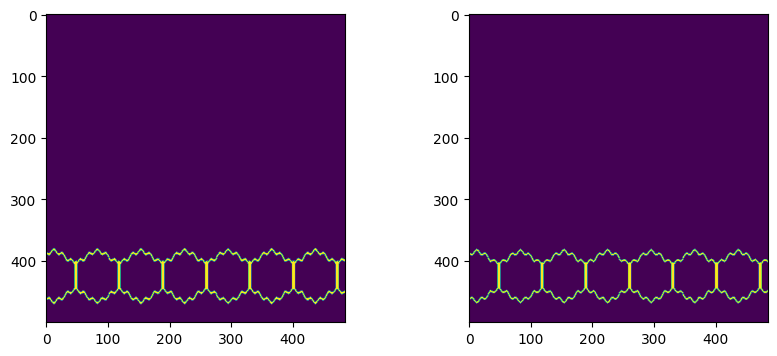

In [216]:
d3_array_5 = d3_array_3+d3_array_4
sety = list(set(minima_coordinates[:, 0]))
setx = list(set(minima_coordinates[:, 1]))
sety = np.array(sety)
setx = np.array(setx)



for i in range(first_nonzero_indices.shape[0]):
    for j in range(first_nonzero_indices.shape[1]):
        if tp == '0':
            if i in sety:
                d3_array_5[first_nonzero_indices[i, j]-2:last_nonzero_indices[i, j], i, j] = 1
            if j in setx:
                d3_array_5[first_nonzero_indices[i, j]-2:last_nonzero_indices[i-1, j], i-1, j] = 1
        if tp == '1' or tp == '2' or tp == '3' or tp == '4':
            if i in sety:
                d3_array_5[first_nonzero_indices[i, j]:last_nonzero_indices[i, j], i, j] = 1
            if j in setx:
                d3_array_5[first_nonzero_indices[i, j]:last_nonzero_indices[i-1, j], i-1, j] = 1

d3_array_5 = sk.morphology.binary_dilation(d3_array_5, footprint=sk.morphology.ball(1))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(get_r(d3_array_5)[430])
plt.subplot(122)
plt.imshow(get_r(d3_array_5)[20])


In [191]:
# tiff.imwrite('./../ppujol/mypose_benchmark/wrinkled_cells_and_junction_tp'+tp+'.tif', d3_array_5.astype(np.uint16), imagej=True)

In [218]:
## Functions

def get_r(image):
    image_r = np.transpose(image, axes=(1,0,2))
    return image_r

def get_top(image_r):
    image = np.transpose(image_r, axes=(1, 2, 0))
    image = np.rot90(image, axes=(1,2))
    return image

def normalize_image(im, mult_factor=1):
    '''
    Normalize image 0-1 and multiply by any factor
    '''
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

def amplify_image(real_im, fake_im):
    amplifications = [real_im.shape[i]/fake_im.shape[i] for i in range(len(real_im.shape))]
    fake_im = zoom(fake_im, (max(amplifications), max(amplifications), max(amplifications)), order=1)
    return fake_im

def realistic_brightness_and_contrast(fake_im, real_im):
    fake_im_modified = normalize_image(fake_im, real_im.max())
    fake_im_modified = np.clip(fake_im_modified.astype(int) - (fake_im_modified.mean()-real_im.mean())/2, 0, 65535).astype(np.uint16) # adjust brightness
    fake_im_modified = np.clip((fake_im_modified - fake_im_modified.mean()) * real_im.std()/fake_im_modified.std() + fake_im_modified.mean(), 0, 65535).astype(np.uint16) # adjust contrast
    return fake_im_modified

def random_noise(image, sum_to_noise=14):
    image_noise = copy(image)+np.random.normal(0, 2, image.shape)+sum_to_noise
    return image_noise

def blur(image, norm_top=10000):
    fake_im_modified = image.astype(np.float64)
    image_gaussian = gaussian_filter(image, 2)
    # image_gaussian = gaussian_filter(image, 5)
    # fake_im_modified_blur = normalize_image(fake_im_modified_blur, 65535).astype(np.uint16)
    image_gaussian = normalize_image(image_gaussian, norm_top).astype(np.uint16)
    return image_gaussian

def movement_blur(image, size=9):
    image_r = get_r(image)
    kernel_z = np.zeros((size, size))
    kernel_z[size//2+1, :] = 1
    kernel_z = kernel_z/kernel_z.sum()
    
    image_movement_r = np.zeros_like(image_r)
    for i in range(image_r.shape[0]):
        slice_movement_r = image_r[i]
        slice_movement_r = cv2.filter2D(slice_movement_r, -1, kernel_z)
        image_movement_r[i] = slice_movement_r

    image_movement = get_top(image_movement_r)
    return image_movement

def salt_and_pepper_noise(image, salt_ratio=0.05, pepper_ratio=0.05):
    z, y, x = image.shape
    salt = np.random.rand(z, y, x) < salt_ratio
    pepper = np.random.rand(z, y, x) < pepper_ratio
    noisy_image = np.copy(image)
    noisy_image[salt] = image.mean()
    noisy_image[pepper] = 0
    return noisy_image

def black_45(image, real_image):
    image_r = get_r(image)
    real_image_r = get_r(real_im) 

    non_zero = np.sum(real_image_r, axis=0)
    black_white_r = np.zeros((real_image_r.shape))
    black_white_r[:, non_zero != 0] = 1

    ## Second axis _r
    amplification = image_r.shape[1]/black_white_r.shape[1]
    black_white_r = zoom(black_white_r, (amplification, amplification, amplification), order=1)
    
    ## Third axis _r
    middle_index = black_white_r.shape[2]//2-25
    while (image_r.shape[2] < black_white_r.shape[2]):
        black_white_r = np.concatenate((black_white_r[:, :, :middle_index], black_white_r[:, :, middle_index+50:]), axis=2) ## Remove slices
    
    while (image_r.shape[2] > black_white_r.shape[2]):
        number_slices = image_r.shape[2]-black_white_r.shape[2]
        slice_of_ones = np.ones((black_white_r.shape[0], black_white_r.shape[1], number_slices))
        black_white_r = np.concatenate((black_white_r[:, :, :middle_index], slice_of_ones, black_white_r[:, :, middle_index:]), axis=2) ## Add slices
    
    ##  First axis _r
    middle_index = black_white_r.shape[0]//2-25
    while (image_r.shape[0] < black_white_r.shape[0]):
        black_white_r = np.concatenate((black_white_r[:middle_index, :, :], black_white_r[middle_index+50:, :, :]), axis=0) ## Remove slices
    
    while (image_r.shape[0] > black_white_r.shape[0]):
        number_slices = image_r.shape[0]-black_white_r.shape[0]
        shaped_slices = black_white_r[middle_index, ...]
        shaped_slices = np.expand_dims(shaped_slices, axis=0)
        shaped_slices = np.repeat(shaped_slices, number_slices, axis=0)
        black_white_r = np.concatenate((black_white_r[:middle_index, :, :], shaped_slices, black_white_r[middle_index:, :, :]), axis=0) ## Add slices
    
    return get_top(black_white_r*image_r)

def plotcomparisons(real_im, fake_im, slice_r=300, slice_top=200):
    plt.figure(figsize=(15, 12))
    plt.subplot(221)
    plt.imshow(get_r(real_im)[slice_r])
    plt.colorbar()
    plt.subplot(222)
    plt.imshow(get_r(fake_im)[slice_r])
    plt.colorbar()
    
    plt.subplot(223)
    plt.imshow(real_im[slice_top])
    plt.colorbar()
    plt.subplot(224)
    plt.imshow(fake_im[slice_top])
    plt.colorbar()

    pass

def valuecomparisons(real_im, fake_im):
    print(f"Shape of the real image = {real_im.shape}")
    print(f"Shape of the fake image = {fake_im.shape}")
    
    print(f"Max intensity of the real image = {real_im.max()}")
    print(f"Max intensity of the fake image = {fake_im.max()}")
    
    print(f"Min intensity of the real image = {real_im.min()}")
    print(f"Min intensity of the fake image = {fake_im.min()}")
    
    print(f"Brightness - Mean intensity of the real image = {real_im.mean()}")
    print(f"Brightness - Mean intensity of the fake image = {fake_im.mean()}")
    
    print(f"Contrast - Std intensity of the real image = {real_im.std()}")
    print(f"Contrast - Std intensity of the fake image = {fake_im.std()}")

    pass

In [217]:
dome_monolayer = copy(d3_array_5)
# dome_monolayer = zoom(dome_monolayer, (0.3, 0.3, 0.3), order=1)

tp = str(tp)
fake_im = copy(dome_monolayer)
if tp == '2':
    fake_im = fake_im[100:400]
# if tp == '4':
#     fake_im = fake_im[110:410]
else:
    fake_im = fake_im[200:]
if tp == '0':
    fake_im = np.concatenate((fake_im[20:], fake_im[:20]))
real_im = sk.io.imread('./../ppujol/dottamine_benchmark/realDomeExample62tp0.tif')
# real_im = real_im[0]

real_im_r = get_r(real_im)
fake_im_r = get_r(fake_im)

tiff.imwrite('./../ppujol/mypose_benchmark/tp'+tp+'/clear_wrinkled_cells_tp'+tp+'.tif', fake_im.astype(np.uint16), imagej=True)

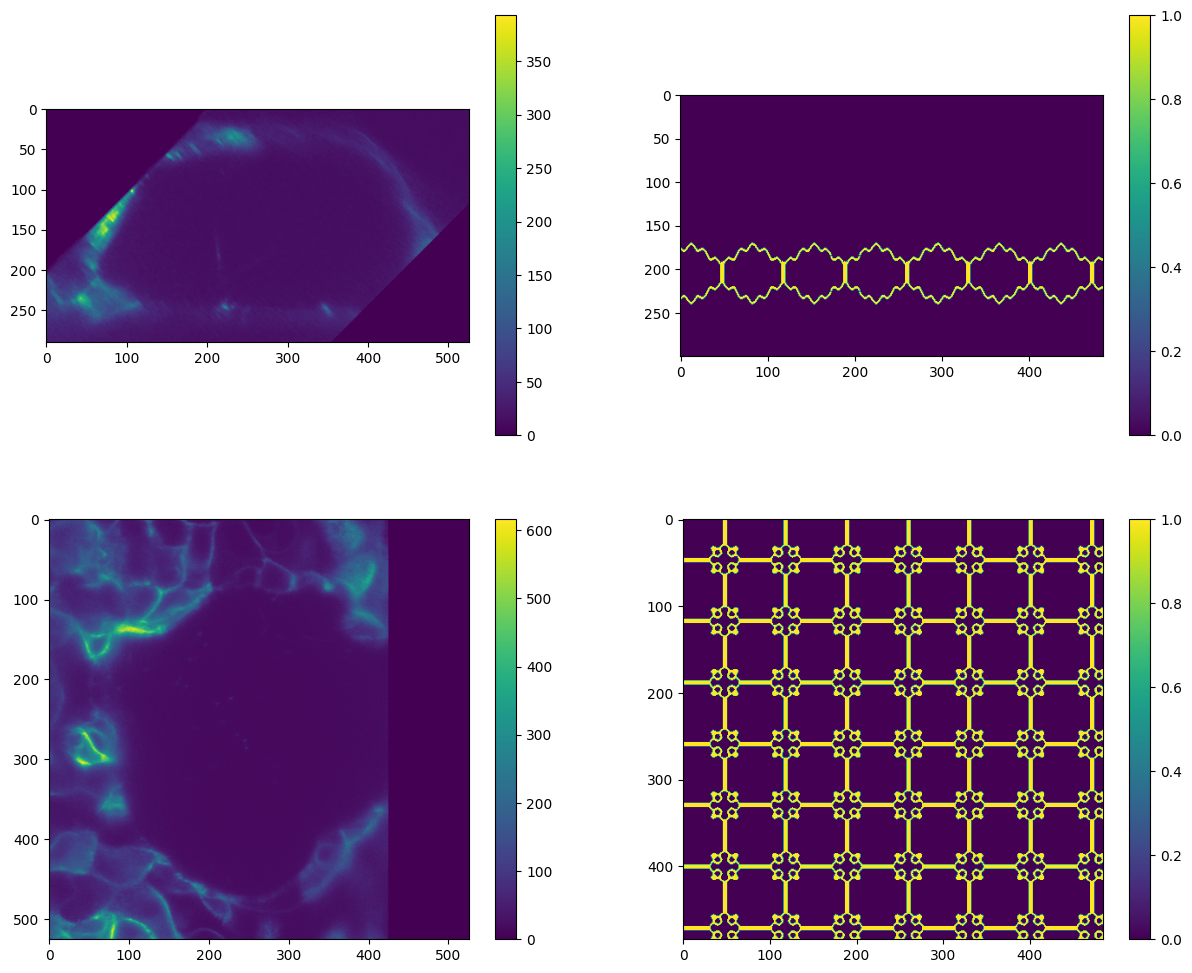

In [219]:
plotcomparisons(real_im, fake_im, slice_r=250, slice_top=220)

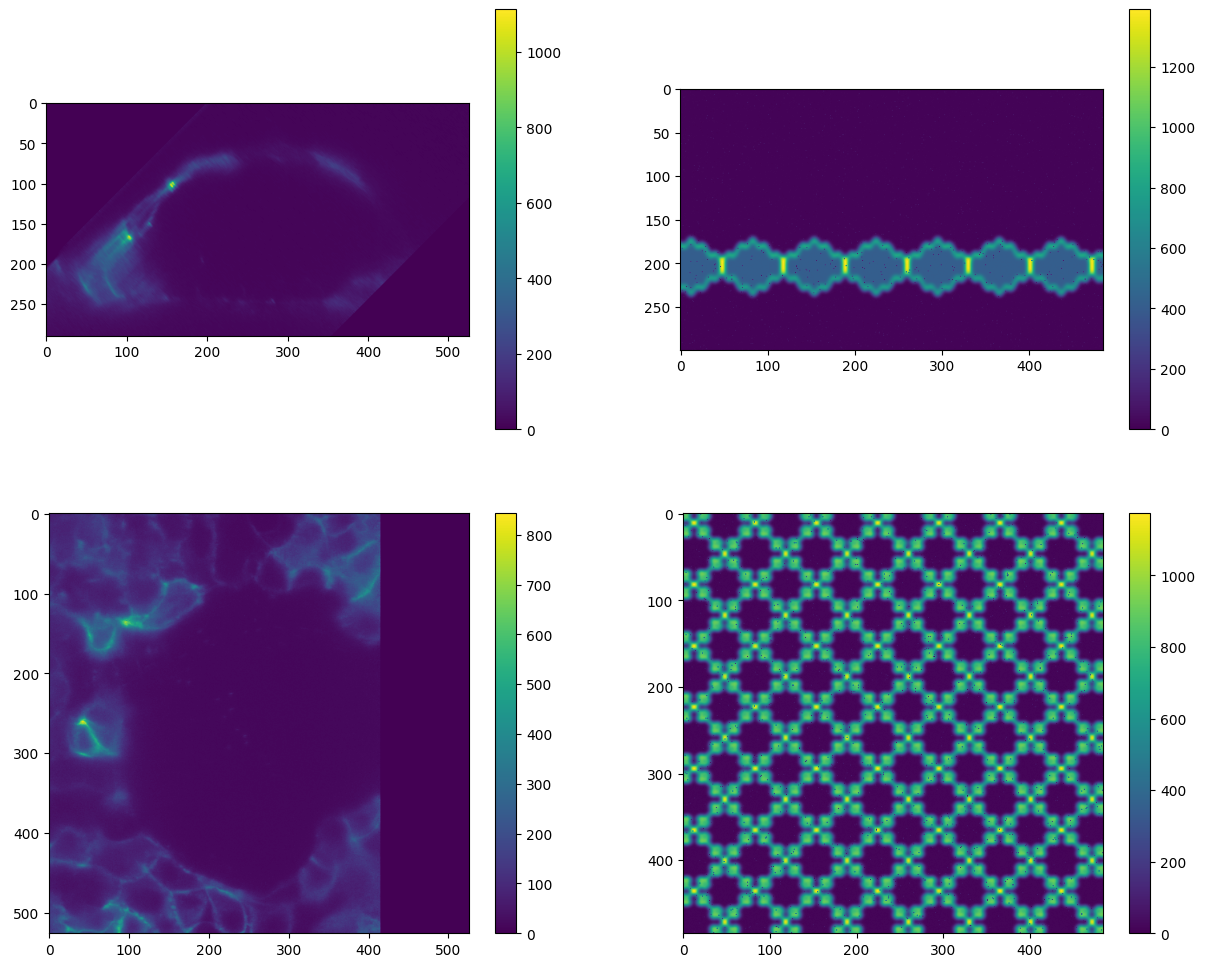

In [220]:
# fake_im_cut = normalize_image(copy(fake_im), 65535).astype(np.uint16)

fake_im_cut = copy(fake_im).astype(np.uint16)

# np.random.seed(509)
# delta = int(49)
# for i in range(0, fake_im_cut.shape[1], delta):
#     # print(i)
#     for j in range(0, fake_im_cut.shape[2], delta):
#         fake_im_cut[:, i:i+delta, j:j+delta] = fake_im_cut[:, i:i+delta, j:j+delta] * np.random.normal() * 1000000





fake_im_cut = realistic_brightness_and_contrast(fake_im_cut, real_im)
# valuecomparisons(real_im, fake_im_cut)

# if tp == '0':
#     fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp0"""
# if tp == '1':
#     fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp1"""
# if tp == '2':
#     fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## This is the cut to have the same size as the original image of """tp2"""
# if tp == '3':
#     fake_im_cut = fake_im_cut[160:, 20:304, 20:304] ## Image of """tp3"""
# if tp == '4':
#     fake_im_cut = fake_im_cut[180:, 20:314, 20:314] ## Image of """tp4"""
# if tp == '5':
#     fake_im_cut = fake_im_cut[180:, 20:314, 20:314] ## Image of """tp5"""
# if tp == '6':
#     fake_im_cut = fake_im_cut[205:, 50:284, 50:284] ## Image of """tp6"""

# fake_im_cut = amplify_image(real_im, fake_im_cut)

fake_im_cut = blur(fake_im_cut, norm_top=real_im.max())

fake_im_cut = movement_blur(fake_im_cut, size=5)


fake_im_cut = random_noise(fake_im_cut)
fake_im_cut = salt_and_pepper_noise(fake_im_cut, salt_ratio=0.005, pepper_ratio=0.005)


# # if tp == '3':
# #     fake_im_cut = fake_im_cut[20:320, :, :] ## Final cut of """tp3"""

# fake_im_cut = realistic_brightness_and_contrast(fake_im_cut, real_im)
fake_im_cut = normalize_image(fake_im_cut, real_im.max())


# fake_im_cut = black_45(fake_im_cut, real_im)


plotcomparisons(real_im, fake_im_cut, slice_r=150, slice_top=230)


In [221]:
valuecomparisons(real_im, fake_im_cut)

Shape of the real image = (290, 526, 526)
Shape of the fake image = (300, 485, 485)
Max intensity of the real image = 1703
Max intensity of the fake image = 1703.0
Min intensity of the real image = 0
Min intensity of the fake image = 0.0
Brightness - Mean intensity of the real image = 26.20035591238052
Brightness - Mean intensity of the fake image = 81.48545323833763
Contrast - Std intensity of the real image = 42.70399937978572
Contrast - Std intensity of the fake image = 210.94615215400634


In [222]:
tiff.imwrite('./../ppujol/mypose_benchmark/tp'+tp+'/modified_wrinkled_cells_tp'+tp+'.tif', fake_im_cut.astype(np.uint16), imagej=True)